## Mask R-CNN Visualization

This notebook performs inference on a trained mask r-cnn model, and visualizes the result.

The instruction below demonstrate visualizing model performance on the validation data, and applying the model to new images.

First, create a new model, and map the weights of a previously trained model onto it.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
#os.environ['TF_CUDNN_DETERMINISTIC'] = 'true'
os.environ['TENSORPACK_FP16'] = 'true'
sys.path.append('/mask-rcnn-tensorflow/MaskRCNN')
import tensorflow as tf
import tqdm
import numpy as np
from model.generalized_rcnn import ResNetFPNModel
from skimage import io
import matplotlib.pyplot as plt
from config import finalize_configs, config as cfg
from dataset import DetectionDataset
from tensorpack import *
from data import get_viz_dataflow
from viz import draw_annotation, draw_final_outputs, draw_predictions, draw_proposal_recall, gt_mask, apply_masks, draw_outputs
from pathlib import Path

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.








In [5]:
# create a mask r-cnn model
MODEL = ResNetFPNModel(True)
# file path to previoulsy trained mask r-cnn model
trained_model = '/logs/train_log/model-45000.index'
# fixed resnet50 backbone weights
cfg.BACKBONE.WEIGHTS = '/data/pretrained-models/ImageNet-R50-AlignPadding.npz'
# dataset location
# calling detection dataset gets the number of coco categories 
# and saves in the configuration
DetectionDataset()
cfg.DATA.BASEDIR = '/data/'
df = get_viz_dataflow('val2017')
df.reset_state()
finalize_configs(is_training=False)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
[1111 14:11:36 @dataset.py:50] Instances loaded from /data/annotations/instances_val2017.json.


100%|██████████| 5000/5000 [00:00<00:00, 7426.05it/s]

[1111 14:11:37 @timer.py:50] Load Load annotations for val2017 finished, time:0.6795sec.


[1111 14:11:37 @data.py:130] Ground-Truth Boxes:
| class          |   #box |
|:---------------|-------:|
| BG             |      0 |
| person         |  10777 |
| bicycle        |    314 |
| car            |   1918 |
| motorcycle     |    367 |
| airplane       |    143 |
| bus            |    283 |
| train          |    190 |
| truck          |    414 |
| boat           |    424 |
| traffic light  |    633 |
| fire hydrant   |    101 |
| stop sign      |     75 |
| parking meter  |     60 |
| bench          |    411 |
| bird           |    424 |
| cat            |    202 |
| dog            |    218 |
| horse          |    272 |
| sheep          |    354 |
| cow            |    372 |
| elephant       |    252 |
| bear           |     71 |
| zebra          |    266 |
| giraffe        |    232 |
| backpack       |    371 |
| umbrella       |    407 |
| handbag        |    540 |
| tie            |    252 |
| suitcase       |    299 |
| frisbee        |    115 |
| skis           |    241 |

In [6]:
# Create an inference model
# PredictConfig takes a model, input tensors and output tensors
pred = OfflinePredictor(PredictConfig(
        model=MODEL,
        session_init=get_model_loader(trained_model),
        input_names=['images', 'orig_image_dims'],
        output_names=[
            'generate_{}_proposals_topk_per_image/boxes'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'generate_{}_proposals_topk_per_image/scores'.format('fpn' if cfg.MODE_FPN else 'rpn'),
            'fastrcnn_all_scores',
            'output/boxes',
            'output/scores',
            'output/labels',
            'output/masks'
        ]))

[1111 14:11:40 @varmanip.py:196] Checkpoint path /logs/train_log4/model-45000.index is auto-corrected to /logs/train_log4/model-45000.





[1111 14:11:40 @registry.py:127] conv0 input: [None, 3, None, None]
Use channels_first data format


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[1111 14:11:41 @registry.py:135] conv0 output: [None, 64, None, None]
[1111 14:11:41 @registry.py:127] pool0 input: [None, 64, None, None]

[1111 14:11:41 @registry.py:135] pool0 output: [None, 64, None, None]
[1111 14:11:41 @registry.py:127] group0/block0/conv1 input: [None, 64, None, None]
Use channels_first data format
[1111 14:11:41 @registry.py:135] group0/block0/conv1 output: [None, 64, None, None]
[1111 14:11:41 @registry.py:127] group0/block0/conv2 input: [None, 64, None, None]
Use channels_first data format
[1111 14:11:41 @registry.py:135] group0/block0/conv2 output: [None, 64, None, None]
[1111 14:11:41 @registry.py:127] gr

Use channels_first data format
[1111 14:11:43 @registry.py:135] group2/block1/conv1 output: [None, 256, None, None]
[1111 14:11:43 @registry.py:127] group2/block1/conv2 input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:43 @registry.py:135] group2/block1/conv2 output: [None, 256, None, None]
[1111 14:11:43 @registry.py:127] group2/block1/conv3 input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:43 @registry.py:135] group2/block1/conv3 output: [None, 1024, None, None]
[1111 14:11:43 @registry.py:127] group2/block2/conv1 input: [None, 1024, None, None]
Use channels_first data format
[1111 14:11:43 @registry.py:135] group2/block2/conv1 output: [None, 256, None, None]
[1111 14:11:43 @registry.py:127] group2/block2/conv2 input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:43 @registry.py:135] group2/block2/conv2 output: [None, 256, None, None]
[1111 14:11:43 @registry.py:127] group2/block2/conv3 input: [None, 256, None, None

[1111 14:11:44 @registry.py:135] fpn/maxpool_p6 output: [None, 256, None, None]
[1111 14:11:44 @registry.py:135] fpn output: [None, 256, None, None],[None, 256, None, None],[None, 256, None, None],[None, 256, None, None],[None, 256, None, None]
[1111 14:11:44 @registry.py:127] rpn input: [None, 256, None, None]
[1111 14:11:44 @registry.py:127] rpn/conv0 input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:44 @registry.py:135] rpn/conv0 output: [None, 256, None, None]
[1111 14:11:44 @registry.py:127] rpn/class input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:44 @registry.py:135] rpn/class output: [None, 3, None, None]
[1111 14:11:44 @registry.py:127] rpn/box input: [None, 256, None, None]
Use channels_first data format
[1111 14:11:44 @registry.py:135] rpn/box output: [None, 12, None, None]
[1111 14:11:44 @registry.py:135] rpn output: [None, None, None, 3],[None, 12, None, None]
Use channels_first data format
Use channels_first data format
Us

df is a generator that will produce images and annotations. Images are loaded in BGR format, so need to be flipped to RGB.

In [65]:
#an_image = next(df.get_data())
img = an_image['images']
gt_boxes = an_image['gt_boxes']
gt_labels = an_image['gt_labels']
gt_masks = an_image['gt_masks']
img = img[:,:,[2,1,0]]

Display the image by itself.

In [68]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))

Add in ground truth bounding boxes and labels using the draw_annotation function.

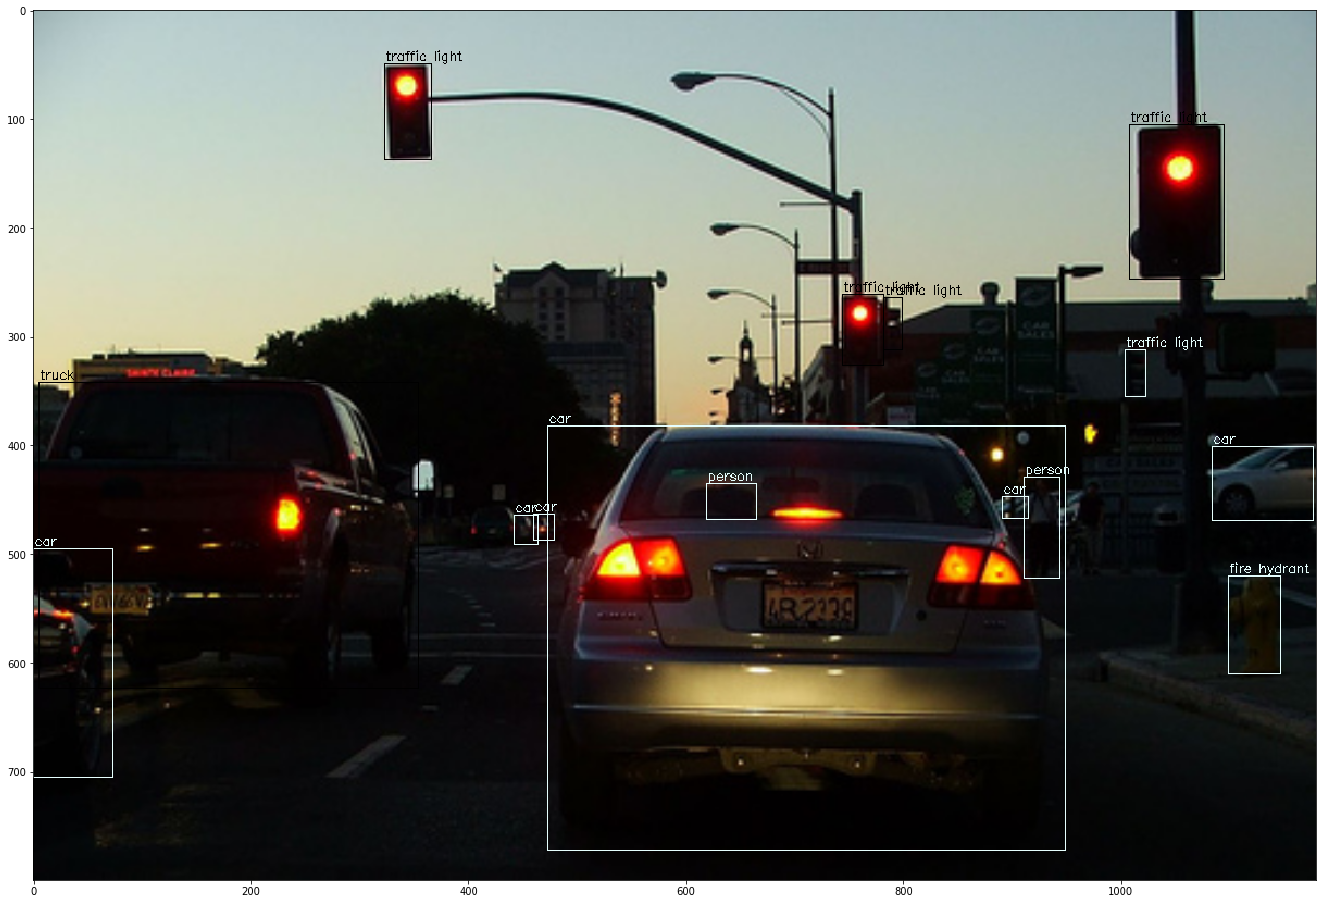

In [73]:
gt_viz = draw_annotation(img, gt_boxes, gt_labels)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(gt_viz.astype(int))

Pass this image to the model. Get region proposal network outputs and final outputs.

In [70]:
rpn_boxes, rpn_scores, all_scores, final_boxes, final_scores, final_labels, masks = pred(np.expand_dims(img, axis=0),
                                                                                  np.expand_dims(np.array(img.shape), axis=0))
rpn_boxes = rpn_boxes[:,1:]

First plot all rpn outputs. This is going to be a huge mess of boxes, mostly tagged as background, but worth looking at to determine how the model is working.

In [71]:
rpn_viz = draw_predictions(img, rpn_boxes, all_scores)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_viz.astype(int))

Let's remove all the background boxes.

In [72]:
no_bg = np.where(all_scores.argmax(axis=1)!=0)
rpn_no_bg_viz = draw_predictions(img, rpn_boxes[no_bg], all_scores[no_bg])
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_no_bg_viz.astype(int))

After the region proposal network, the model applies a nonmax supression that removes many of the redudant boxes, then produces the model's final output. Let's plot all those final output boxes.

In [74]:
final_all_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_all_viz.astype(int))

Notice there is still some overlap, and a lot of extra boxes versus what we have on the ground truth. At this point, we want to pick a threshold for what boxes to show. Often this is set at .5 or .95. Let's try .5.

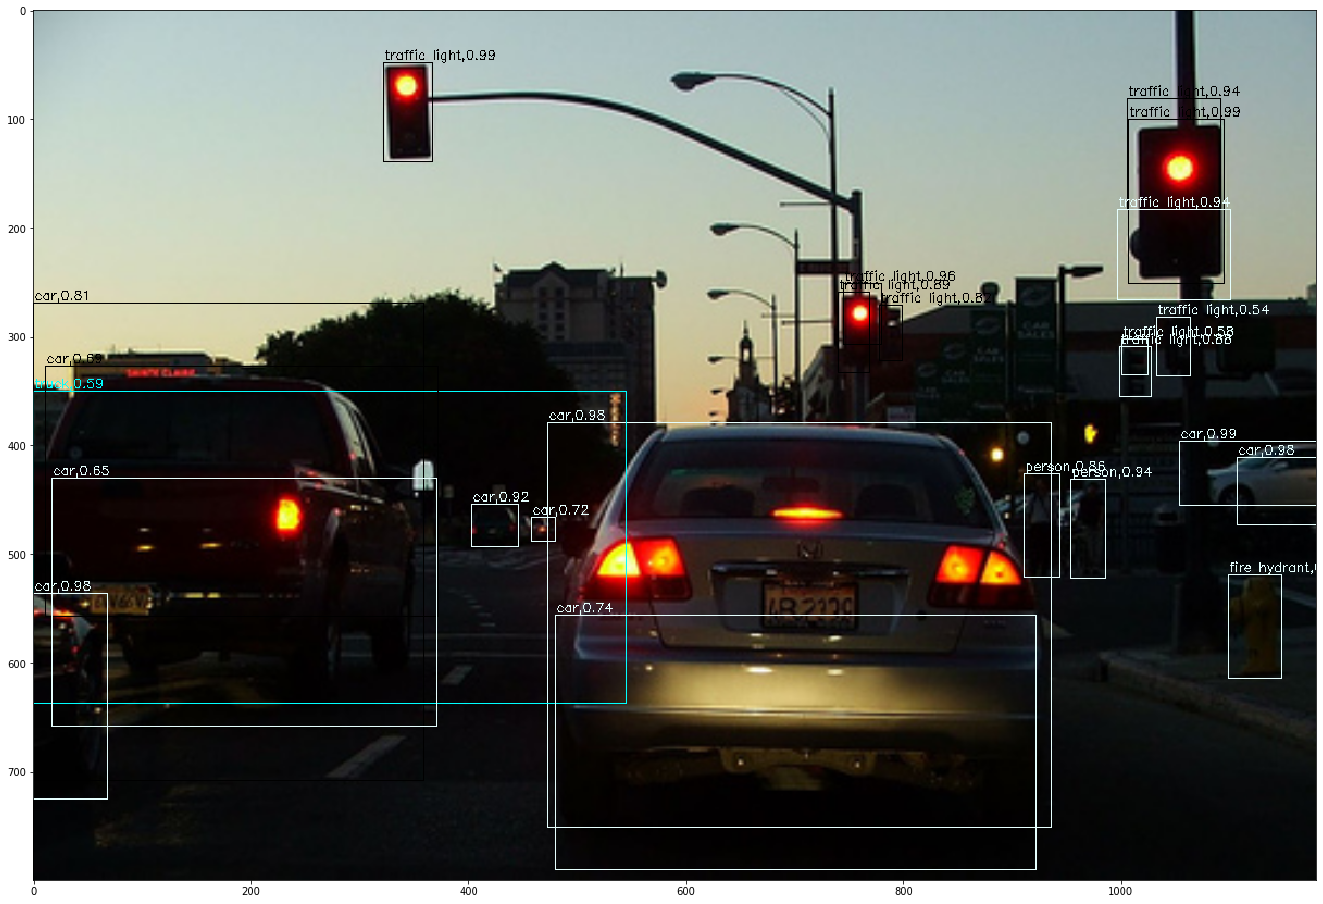

In [75]:
final_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))

This is starting to look more informative. Next, lets plot all the ground truth masks in the image.

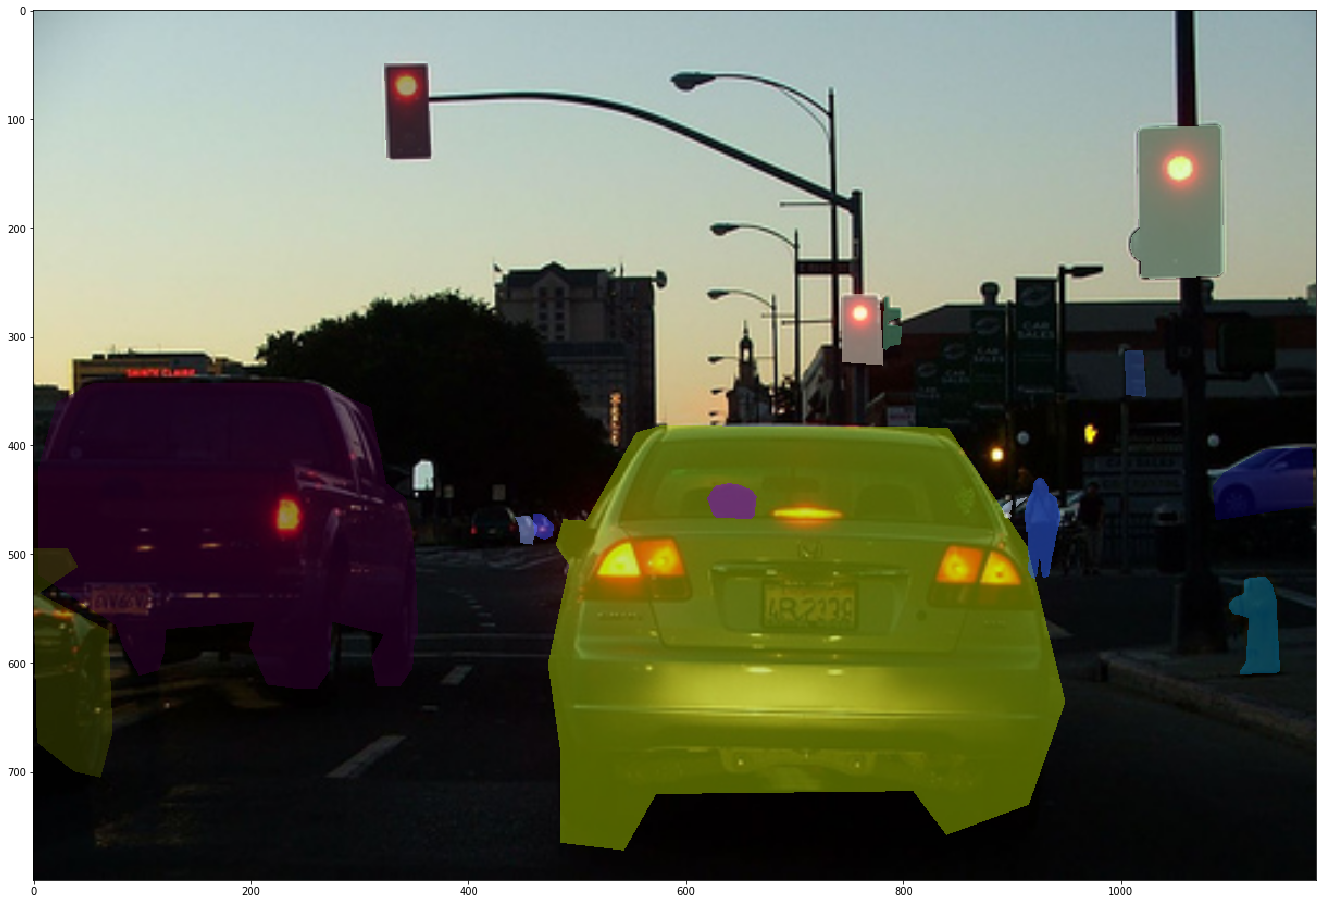

In [76]:
mask_gt_viz = gt_mask(img, gt_masks)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(mask_gt_viz.astype(int))

And now plot our model's predictions for the masks, using the same .5 threshold for the boxes. We also now have a mask threshold. Within each box all pixels are given a probability of being part of the object. if the threshold is set at 0 the entire box will be the mask.

In [78]:
masked_box_viz = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.5, mask_threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_box_viz.astype(int))

If we increase the threshold, the masks will pull in tighter around the objects themselves.

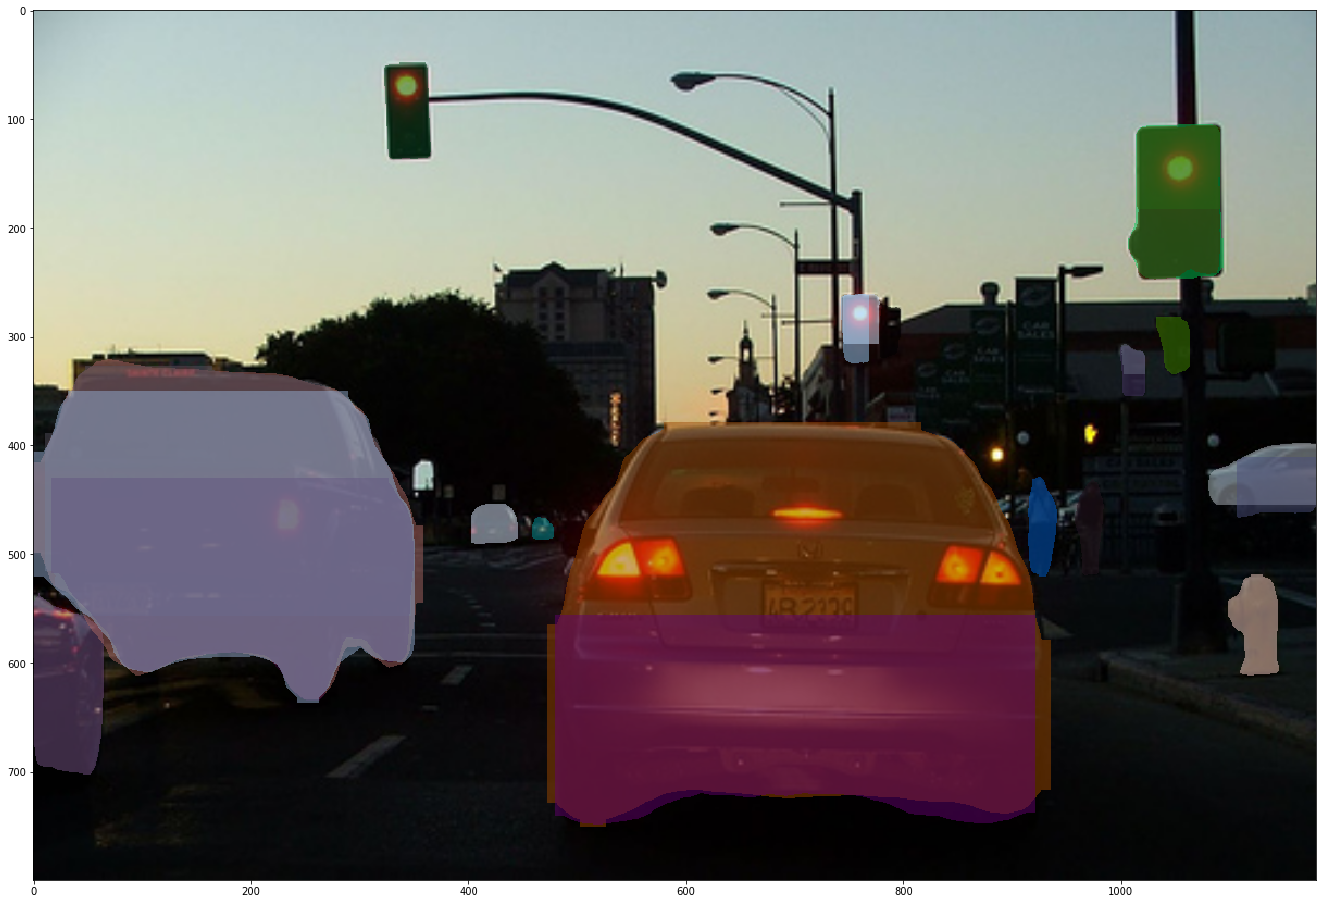

In [79]:
masked_viz = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.5, mask_threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_viz.astype(int))

Now let's try a totally new image. You can use any image you want, but below we've included some examples from the validation data and from websites.

In [88]:
#images_path = np.random.choice(list(Path('/data/val2017/').glob('*.jpg')))
#images_path = "https://www.washingtonpost.com/resizer/s8Lyf-phIfV0FYCmrBR1j5EIHyk=/1248x701/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/L5GO6PX3H4I6TCIGVNVWBXUREQ.jpg"
#images_path = "https://www.washingtonpost.com/resizer/wSFAIAbCGCi-_KhJyseh2rqSF-g=/1248x701/arc-anglerfish-washpost-prod-washpost.s3.amazonaws.com/public/3GGBUPK3GZA2DMKRXSKD4TP34M"
images_path = "https://i.kinja-img.com/gawker-media/image/upload/c_scale,f_auto,fl_progressive,q_80,w_1600/ekpvcpwo560egadg2mvm.jpg"
#images_path = "https://fivethirtyeight.com/wp-content/uploads/2019/11/GettyImages-1182527640-1-e1572981138469.jpg?w=1150"
#images_path = "https://fivethirtyeight.com/wp-content/uploads/2019/10/GettyImages-1001876214-4x3.jpg?w=1150"
#images_path = "https://cdn.britannica.com/08/187508-050-D6FB5173/Shanghai-Tower-Gensler-San-Francisco-world-Oriental-2015.jpg"
img = io.imread(images_path)

In [90]:
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(img.astype(int))

In [91]:
rpn_boxes, rpn_scores, all_scores, final_boxes, final_scores, final_labels, masks = pred(np.expand_dims(img, axis=0),
                                                                                  np.expand_dims(np.array(img.shape), axis=0))
rpn_boxes = rpn_boxes[:,1:]

In [83]:
rpn_viz = draw_predictions(img, rpn_boxes, all_scores)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_viz.astype(int))

In [84]:
no_bg = np.where(all_scores.argmax(axis=1)!=0)
rpn_no_bg_viz = draw_predictions(img, rpn_boxes[no_bg], all_scores[no_bg])
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(rpn_no_bg_viz.astype(int))

In [85]:
final_all_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.0)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_all_viz.astype(int))

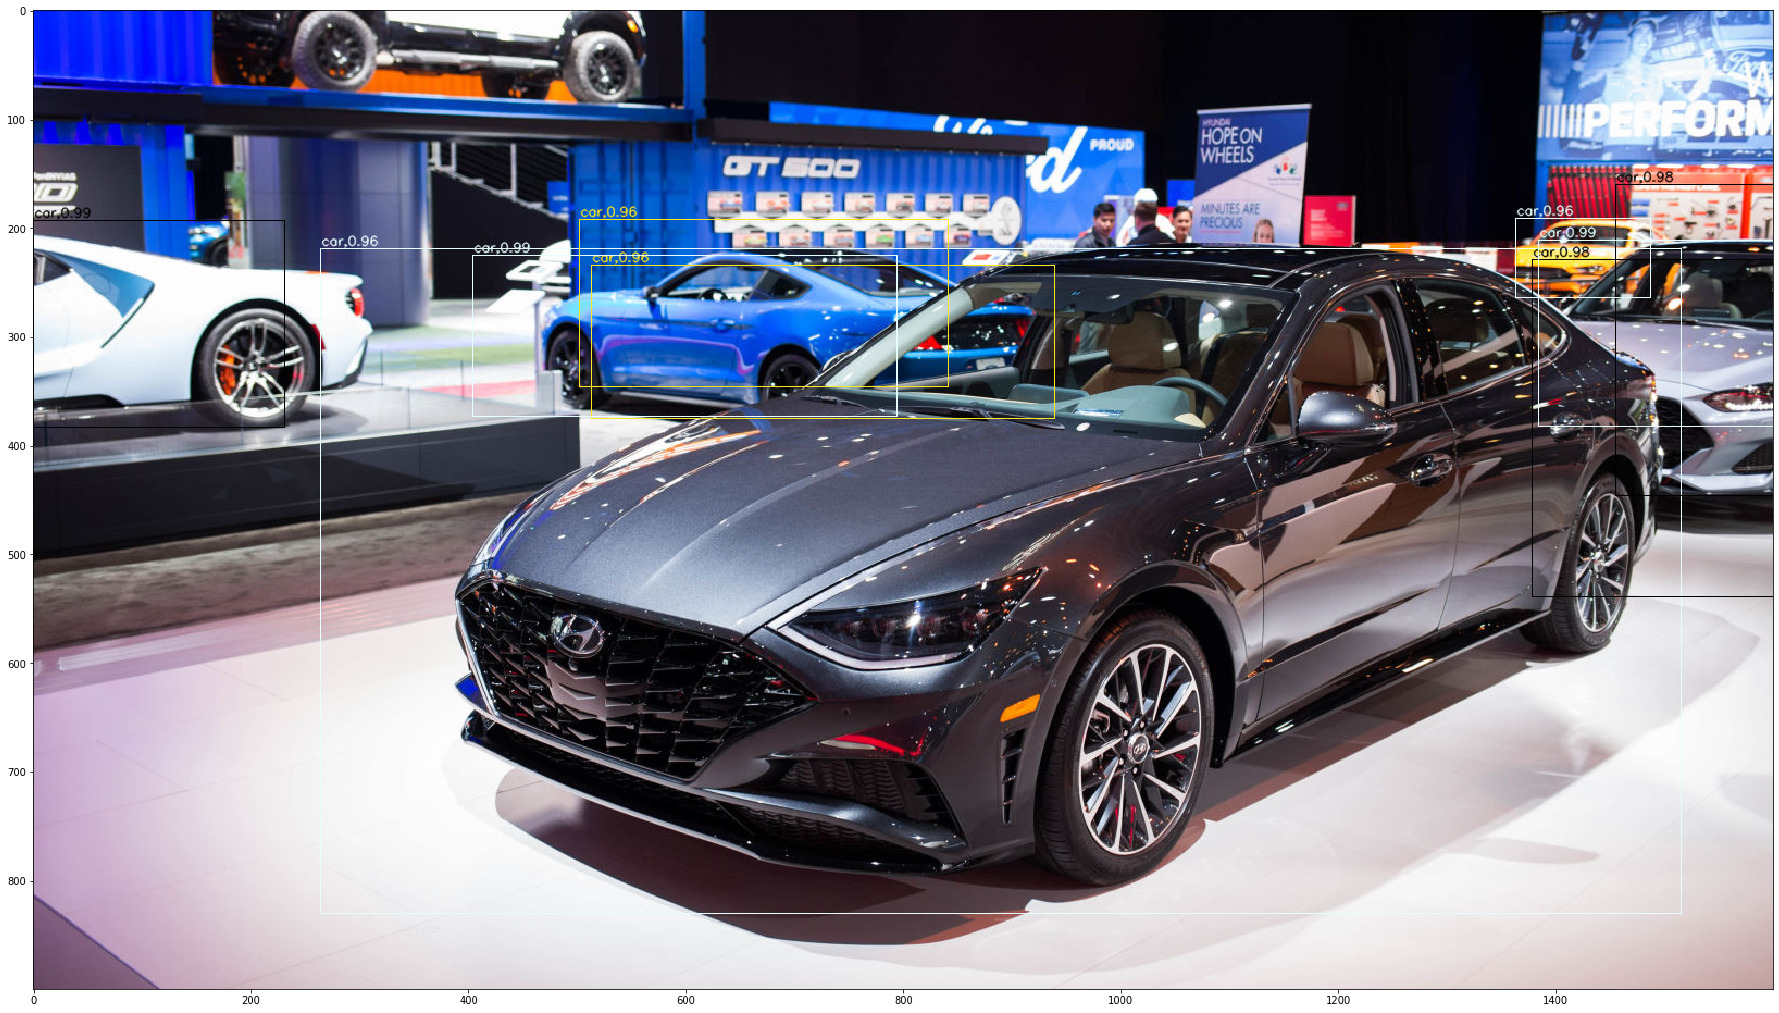

In [92]:
final_viz = draw_outputs(img, final_boxes, final_scores, final_labels, threshold=0.95)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(final_viz.astype(int))

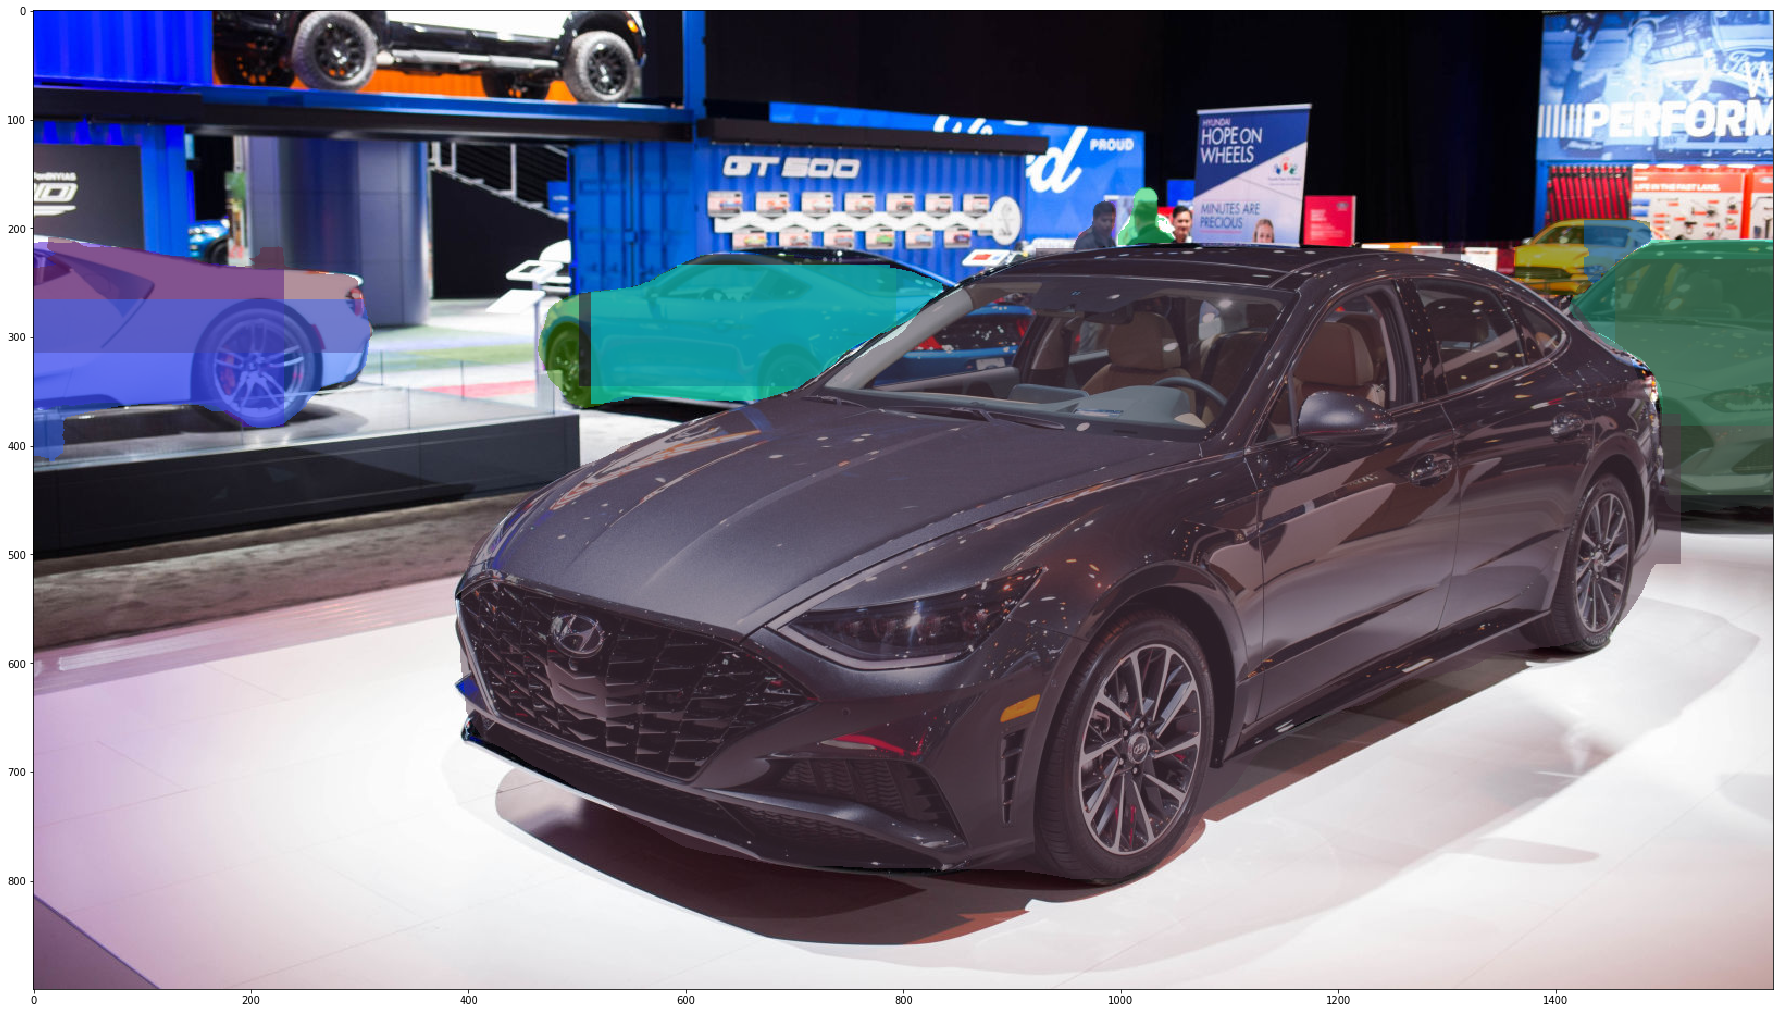

In [93]:
masked_image = apply_masks(img, final_boxes, masks, final_scores, score_threshold=.8, mask_threshold=0.5)
fig,ax = plt.subplots(figsize=(img.shape[1]//50, img.shape[0]//50))
ax.imshow(masked_image.astype(int))